
# kaggleのデータセットを用いてモデルを構築する

### 目的：クラウドファンディングが成功するかを予測するモデルを構築する
### Kickstarter Projects URL:https://www.kaggle.com/kemical/kickstarter-projects

・利用するデータ「ks-projects-201801.csv」（データ数：378,661行15列）

| 列 | 項目 | 項目名 | 欠損有無 | 利用有無 |
| :--- | :--- | :--- | :---: | :---: |
|  1 | ID| 識別ID | - | × |
|  2 | name |名称 | 欠損あり | × |
|  3 | category |カテゴリ | - | × |
|  4 | main_category |主なカテゴリ | - | × |
|  5 | currency |使用通貨 | - | × |
|  6 | deadline |締切日時 | - | ○※期間算出用 |
|  7 | goal |目標調達資金額 | - | ○ |
|  8 | launched |開始日時 | - | ○※期間算出用 |
|  9 | pledged |集まった資金 | - | × |
| 10 | state |プロジェクトの状態 | - | ○※成功と失敗のみ抽出 |
| 11 | backers |支援者数 | - | × |
| 12 | country|国 | - | × |
| 13 | usd_pledged |集まった資金（米ドル） | 欠損あり | × |
| 14 | usd_pledged_real |集まった資金（米ドル） | - | × |
| 15 | usd_goal_real |目標金額（米ドル） | - | ○ |

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数

# 警告非表示
import warnings
warnings.filterwarnings('ignore')

In [8]:
# データセット読込
#df= pd.read_csv('./ks-projects-201801.csv')
df= pd.read_csv('./ks-projects-201801.csv')

#print("\n▼ 欠損項目を確認")
#print(df.isnull().sum())

#print("\n▼ 各項目の項目値を確認")
#print(df['state'].unique())
#print(df['main_category'].unique())
#print(df['category'].unique())
#print(df['currency'].unique())
#print(df['country'].unique())

# 欠損項目および不要項目を削除
df = df.drop(['ID','name','usd pledged','category','country','goal'], axis=1)
# 事前に予測できない項目を削除
df = df.drop(['backers','pledged','usd_pledged_real'], axis=1)

# 開始日時と締切日時から期間(period)を算出
df['deadline'] = pd.to_datetime(df['deadline'], errors = 'coerce')
df['launched'] = pd.to_datetime(df['launched'], errors = 'coerce')
df['period'] = (df['deadline'] - df['launched']).dt.days
df = df.drop(['launched','deadline'], axis=1)

# 数値項目は、数値に変換
df['usd_goal_real'] = pd.to_numeric(df['usd_goal_real'], errors ='coerce')
df['period'] = pd.to_numeric(df['period'], errors ='coerce')

# 目標金額を抽出条件に追加
#df = df[(df['usd_goal_real'] <= 5000)]
# 状態が成功または失敗のデータを抽出
df = df[(df['state'] == 'successful') | (df['state'] == 'failed')]

# 状態が成功ならば（1：True），失敗であれば（0：False）に変更
df['state'] = df['state'] == 'successful'

# ダミー変換
#df_dummy1 = pd.get_dummies(df['main_category'])
#df_dummy2 = pd.get_dummies(df['currency'])
#df = pd.concat([df.drop(['main_category'],axis=1),df_dummy1],axis=1)
#df = pd.concat([df.drop(['currency'],axis=1),df_dummy2],axis=1)

# データ並び替え
df = df.ix[:,[2,1,0,3,4]]
#df = df.ix[:,[2,1,0,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]]

print("\n▼ csvデータ確認")
display(df.head())

print("\n▼ 状態別件数確認")
print(df.groupby('state').count())

print("\n▼ 統計量確認")
df.describe()
#print(df.info())



▼ csvデータ確認


,state,currency,main_category,usd_goal_real,period
0,False,GBP,Publishing,1533.95,58
1,False,USD,Film & Video,30000.00,59
2,False,USD,Film & Video,45000.00,44
3,False,USD,Music,5000.00,29
5,True,USD,Food,50000.00,34



▼ 状態別件数確認
       currency  main_category  usd_goal_real  period
state                                                
False    197719         197719         197719  197719
True     133956         133956         133956  133956

▼ 統計量確認


,usd_goal_real,period
count,3.316750e+05,331675.000000
mean,4.151000e+04,32.954902
std,1.108930e+06,12.713329
min,1.000000e-02,0.000000
25%,2.000000e+03,29.000000
50%,5.000000e+03,29.000000
75%,1.500000e+04,35.000000
max,1.663614e+08,91.000000


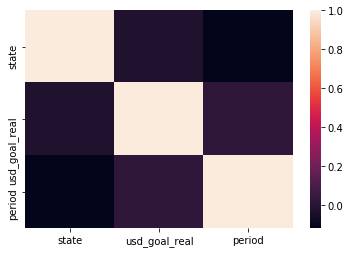

In [10]:
# 相関係数をヒートマップにして可視化
df.corr()
sns.heatmap(df.corr())
plt.show()

In [ ]:
# ロジスティック回帰
X = df[['period','usd_goal_real']].values # 説明変数
y = df['state'].values

#いろんなモデルを計算できる汎用的関数
clf = SGDClassifier(loss='log',           # ロジスティック回帰を指定
                    penalty='none',       # 正則化を入れる場合はL1､L2→Day2で実施
                    max_iter=10000,       # 繰り返し計算時の強制的終了値、誤差が収束すれば利用しない。
                    fit_intercept=True,   # 切片を有効にするかどうか
                    random_state=1234,    # 乱数のシード
                    tol=1e-3              # 収束する誤差の指定
                   )

# 学習
clf.fit(X, y)

# 係数（重み）を取り出す
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]

print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))

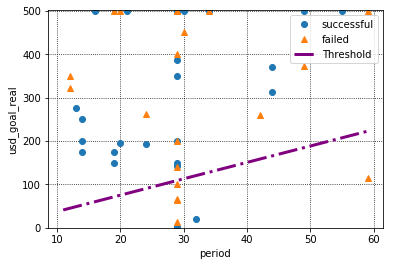

In [7]:
x1, x2 = df["period"].values, df["usd_goal_real"].values 

# データをプロット
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')

plt.plot(x1[y], x2[y], 'o', color='C0', label='successful')
plt.plot(x1[~y], x2[~y], '^', color='C1', label='failed')

#print('\n▼y-------->');print(y)        # 成功or失敗
#print('\n▼x1------->');print(x1)       # x1＝period:期間
#print('\n▼x1[y]---->');print(x1[y])    # periodのうち成功のもの
#print('\n▼x1[~y]--->');print(x1[~y])   # periodのうち失敗のもの
#print('\n▼x2------->');print(x2)       # x2＝goal：目標金額
#print('\n▼x2[y]---->');print(x2[y])    # goalのうち成功のもの
#print('\n▼x2[~y]--->');print(x2[~y])   # goalのうち失敗のもの

# 境界線をプロットして表示
# 紫：境界線
line_x = np.arange(np.min(x1) - 1, np.max(x1) + 1)
line_y = - line_x * w1 / w2 - w0 / w2
plt.plot(line_x, line_y, linestyle='-.', linewidth=3, color='purple', label='Threshold')
plt.ylim([np.min(x2) - 1, np.max(x2) + 1])
plt.legend(loc='best')

plt.xlabel("period")
plt.ylabel("usd_goal_real")
plt.show()

In [252]:
# ラベルを予測
y_est = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

# 成功に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

対数尤度 = -13.816
正答率 = 60.000%
適合率（Precision） = 71.429%
再現率（Recall） = 23.810%
F1値（F1-score） = 35.714%


,予測 = 失敗,予測 = 成功
正解 = 失敗,5,16
正解 = 成功,2,22
